In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import sklearn.preprocessing as pre, sys, pyemma as py, numpy as np, matplotlib.pyplot as plt, glob, pickle, os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]= "2"
sys.path.append('../../hde_vac/')
from hde import HDE, analysis
from temp_tf_load import *
lag_time = 2000
dt = 0.2  # unit: ns

Using TensorFlow backend.


In [2]:
combined_data_s = [np.load('/home/kengyangyao/data/HDE_data/WW_domain/pair_dis_ca_s_%d.npy' % item) for item in range(2)]

In [3]:
tica_coords = pickle.load(open('/home/kengyangyao/data/HDE_data/WW_domain/tica_coords.pkl', 'rb'))

In [4]:
plt.rcParams['font.size'] = 14
def plot_eigenstates_on_tICs(tica_coords, states, timescales=None, n_rows = 2):
    from itertools import combinations
    n_states = states.shape[1]
    tic_index_list = [(i,j) for (i,j) in combinations(range(4), 2)][:n_rows]
    fig, axes = plt.subplots(len(tic_index_list), n_states)

    for xx in range(len(tic_index_list)):
        for item in range(n_states):
            im = axes[xx][item].scatter(tica_coords[:, tic_index_list[xx][0]], 
                                        tica_coords[:, tic_index_list[xx][1]], s=1, 
                                    c=states[:, item], cmap=plt.cm.RdBu_r)
            cbar = fig.colorbar(im, ax=axes[xx][item], label='$\\tilde{\psi}_%d$' % (item + 1))
            if not timescales is None and xx == 0:
                try: axes[xx][item].set_title('timescale = %d' % timescales[item])
                except: pass
            axes[xx][item].set_xlabel('tIC %d' % (tic_index_list[xx][0] + 1))
            axes[xx][item].set_ylabel('tIC %d' % (tic_index_list[xx][1] + 1))
    fig.set_size_inches(5 * n_states, 5 * len(tic_index_list))
    plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.3)
    return fig

## tICA-MSM

In [5]:
assert (type(tica_coords) is list)
cluster = py.coordinates.cluster_kmeans(tica_coords, k=200, n_jobs=1, max_iter=100)

100%|██████████| 100/100 [02:38<00:00, 100.83s/it]                   


In [6]:
msm_tica = py.msm.bayesian_markov_model(cluster.dtrajs, lag=lag_time)
print("Fraction of states used = {:.2f}".format(msm_tica.active_state_fraction))
print("Fraction of counts used = {:.2f}".format(msm_tica.active_count_fraction))
eigvec = msm_tica.eigenvectors_right()
timescales_mean = msm_tica.sample_mean('timescales', k=20)
msm_timescales = timescales_mean
timescales_std = msm_tica.sample_std('timescales', k=20)
tica_msm_coords = [eigvec[item, 1:10] for item in cluster.dtrajs]

100%|██████████| 100/100 [00:06<00:00, 14.85it/s]               


Fraction of states used = 1.00
Fraction of counts used = 1.00


## HDE

In [5]:
hde_skip = 4
data = [item[::hde_skip].astype(np.float32) for item in combined_data_s]

In [6]:
from keras.callbacks import EarlyStopping
earlyStopping = EarlyStopping(monitor='val_loss', patience=50, verbose=1, mode='min', restore_best_weights=True)
hde = HDE(595, n_components=2, lag_time=lag_time // hde_skip, dropout_rate=0, batch_size=500000, n_epochs=10, 
          validation_split=0., batch_normalization=True, learning_rate = 0.01, hidden_size = 100,
          callbacks=[earlyStopping])

In [7]:
hde.callbacks = None

In [8]:
hde.r_degree = 2
#hde._recompile = True
hde.n_epochs = 30
hde.batch_size = 200000
hde.fit(data)

Train on 1420679 samples, validate on 0 samples
Epoch 1/30
1420679/1420679 [==============================] - 7s 5us/step - loss: -1.7725
Epoch 2/30
1420679/1420679 [==============================] - 6s 4us/step - loss: -1.9388
Epoch 3/30
1420679/1420679 [==============================] - 6s 4us/step - loss: -2.1751
Epoch 4/30
1420679/1420679 [==============================] - 6s 4us/step - loss: -2.5240
Epoch 5/30
1420679/1420679 [==============================] - 6s 4us/step - loss: -2.5965
Epoch 6/30
1420679/1420679 [==============================] - 6s 4us/step - loss: -2.6252
Epoch 7/30
1420679/1420679 [==============================] - 6s 4us/step - loss: -2.6328
Epoch 8/30
1420679/1420679 [==============================] - 6s 4us/step - loss: -2.6369
Epoch 9/30
1420679/1420679 [==============================] - 6s 4us/step - loss: -2.6417
Epoch 10/30
1420679/1420679 [==============================] - 6s 4us/step - loss: -2.6445
Epoch 11/30
1420679/1420679 [======================

HDE(activation=None, batch_normalization=True, batch_size=200000,
  callbacks=None, dropout_rate=0, hidden_layer_depth=None,
  hidden_size=None, input_size=595, l2_regularization=0.0, lag_time=500,
  latent_space_noise=0, learning_rate=0.01, n_components=2, n_epochs=30,
  validation_split=0.0, verbose=True)

In [10]:
hde_coords = [hde.transform(item) for item in combined_data_s]

## plot results

In [7]:
its_tica = py.msm.its(cluster.dtrajs, lags=lag_time, nits=2, errors="bayes")

Sampling MSMs:  66%|██████▌   | 33/50 [00:01<00:00, 24.09it/s]

Sampling MSMs:  32%|███▏      | 16/50 [00:00<00:01, 18.14it/s]

Sampling MSMs:  70%|███████   | 35/50 [00:01<00:00, 19.46it/s]


100%|██████████| 50/50 [00:02<00:00, 23.59it/s]               

100%|██████████| 50/50 [00:02<00:00, 20.33it/s]               

100%|██████████| 50/50 [00:02<00:00, 21.43it/s]               

100%|██████████| 50/50 [00:02<00:00, 18.00it/s]               

100%|██████████| 50/50 [00:02<00:00, 18.22it/s]               

100%|██████████| 50/50 [00:03<00:00, 17.39it/s]               

100%|██████████| 50/50 [00:03<00:00, 15.25it/s]               

100%|██████████| 50/50 [00:03<00:00, 14.16it/s]               

100%|██████████| 19/19 [00:42<00:00,  2.93s/it]                        


In [14]:
# lags = its_tica.lags
# z = [hde.transform(item)[:, :2] for item in combined_data_s]
# its = analysis.generate_its(z, lags)
# hde_timescales = hde.timescales_ * hde_skip

In [12]:
lags = its_tica.lags
its_list = []
for item in range(20):
    z = [_1 for _1 in 
              np.load('/home/kengyangyao/data/hde_paper_results/ww_keras_multi_runs/hde_coords_ww_%02d.npy' % item)]
    its = analysis.generate_its(z, lags)
    its_list.append(its)
hde_timescales = np.load('/home/kengyangyao/data/hde_paper_results/ww_keras_multi_runs/hde_timescales_ww_00.npy')
its_list = [item for item in its_list if item[0, 0] > 0]   # filter bad training results

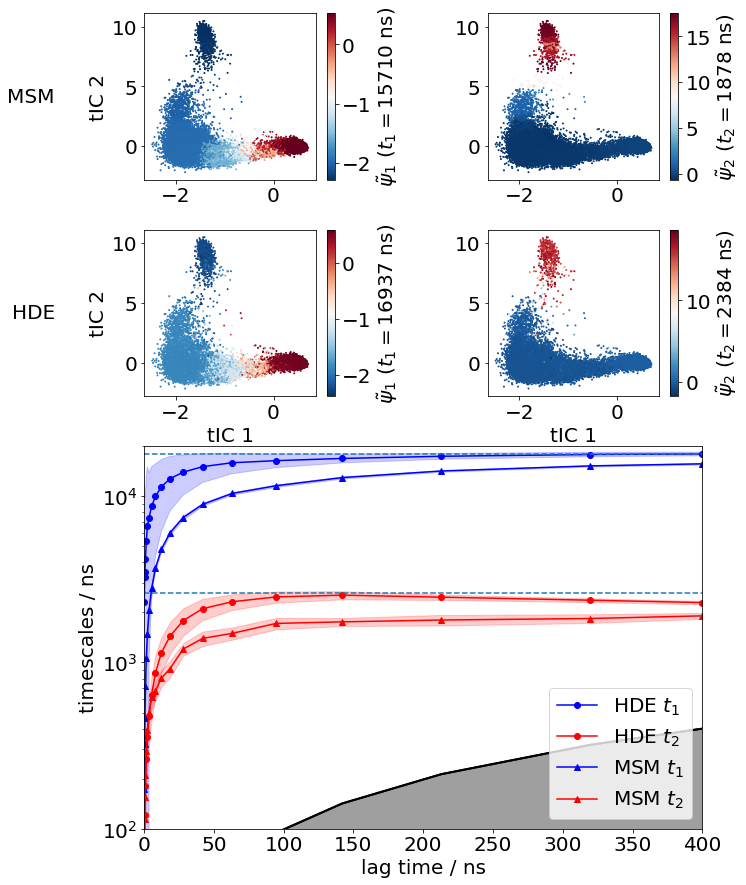

In [44]:
plt.rcParams['font.size'] = 20

skip = 20
coords_list = [tica_msm_coords, z]
timescales_list = [msm_timescales, hde_timescales]

fig = plt.figure(figsize=(10, 15))
tic_index_list = [(0, 1), (0, 1), (0, 2)]

for index_row in range(2):
    for item in range(2):
        ax = plt.subplot2grid((4,2), (index_row, item), fig=fig)
        im = ax.scatter(
            np.concatenate(tica_coords)[::skip, tic_index_list[item][0]], 
            np.concatenate(tica_coords)[::skip, tic_index_list[item][1]], s=1, 
            c=np.concatenate(coords_list[index_row])[::skip, item], cmap=plt.cm.RdBu_r)
        cbar = fig.colorbar(im, ax=ax, label='$\\tilde{\psi}_%d\ (t_%d = %d$ ns)' % (
            item + 1, item + 1, timescales_list[index_row][item] * dt))
        if index_row == 1: ax.set_xlabel('tIC %d' % (tic_index_list[item][0] + 1))
        if item == 0: ax.set_ylabel('tIC %d' % (tic_index_list[item][1] + 1))
    
def plot_its(lags, its_mean, its_std, ax, label_list, marker='o'):
    colors = ['blue', 'red', 'green', 'cyan', 'purple', 'orange', 'violet']
    line_list = []
    for i, ts_mean in enumerate(its_mean):
        ts_std = its_std[i]
        leg, = ax.plot(lags, ts_mean, marker=marker, color=colors[i % len(colors)], label=label_list[i])
        ax.fill_between(lags, ts_mean - 2 * ts_std, ts_mean + 2 * ts_std, alpha=0.2, color=colors[i & len(colors)])
    ax.legend(loc='lower right')
    ax.set_yscale('log')
    ax.plot(lags, lags, linewidth=2, color='black')
    ax.set_xlim([np.min(lags), np.max(lags)])
    ax.fill_between(lags, 1e-3*np.ones(len(lags)), lags, alpha=0.5, color='grey')
    return

ax = plt.subplot2grid((4,2), (2, 0), colspan=2, rowspan=2, fig=fig)
hde_temp = np.array(its_list).reshape(len(its_list), -1, 2).T * dt
plot_its(lags * dt, hde_temp.mean(axis=-1), hde_temp.std(axis=-1), 
         ax, label_list=["HDE $t_1$", "HDE $t_2$"])
plot_its(lags * dt, its_tica.get_sample_mean().T * dt, its_tica.get_sample_std().T * dt,  
         ax, label_list=["MSM $t_1$", "MSM $t_2$"], marker='^')

ax.set_ylim([1e2, 2e4])
ax.set_xlabel('lag time / ns', fontsize=20)
ax.set_ylabel('timescales / ns', fontsize=20)
for item in its.max(axis=0)[:2] * dt:
    ax.axhline(item, linestyle='--')
    
row_label_list = ['MSM', 'HDE']
pad = 30 
axes = fig.get_axes()
for ax, row in zip([axes[0], axes[4]], row_label_list):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                ha='right', va='center')
    
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.6, hspace=0.3)